In [1]:
import pandas as pd

df = pd.read_csv("concatenated_clinical.csv")

print("Önce:", df['treatments.treatment_type'].notna().sum())
df = df[df['cases.submitter_id'].str.startswith("TCGA")]
print("Sonra:", df['treatments.treatment_type'].notna().sum())


# diagnoses.primary_diagnosis'e göre sınıflandır
def classify_diagnosis(value):
    if isinstance(value, str):
        val = value.lower()
        if val.startswith("glio"):
            return "Glioblastoma"
        elif val.startswith("oli"):
            return "Oligodendroglioma"
        elif val.startswith("astro"):
            return "Astrocytoma"
    return "unknown"

for col in df.select_dtypes(include=['float64', 'int64']).columns:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna("Unknown", inplace=True)


df['diagnoses.primary_diagnosis'] = df['diagnoses.primary_diagnosis'].apply(classify_diagnosis)

# Önce 'Unknown' olanları sona at
df = df.sort_values(by='treatments.treatment_type', key=lambda x: x == "Unknown").drop_duplicates(subset=['cases.submitter_id'], keep='first').reset_index(drop=True)


df.to_csv("processed_clinical_with_diagnosis.csv", index=False)

Önce: 2194
Sonra: 1934


/tmp/ipykernel_187519/687367.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/tmp/ipykernel_187519/687367.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# CSV dosyasını oku
df = pd.read_csv("processed_clinical_with_diagnosis.csv")

# Sadece TCGA kayıtlarını al
df = df[df['cases.submitter_id'].str.startswith("TCGA")].reset_index(drop=True)

# Sayısal ve kategorik sütunları ayır
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.difference(['cases.submitter_id']).tolist()

# Sayısal verileri doldur (eksik verileri 0 ile)
numerical_filled = df[numeric_cols].fillna(0)

# Kategorik verileri one-hot encode et
categorical_encoded = pd.get_dummies(df[categorical_cols], dummy_na=True)

deneme = np.concatenate([numerical_filled, categorical_encoded.values], axis=1)

deneme_df = pd.DataFrame(deneme)

deneme_df.to_csv("deneme.csv", index=False)

# Sayısal verileri normalize et
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(numerical_filled)

# Klinik verilerin son hali
processed_clinical_features = np.concatenate([numerical_scaled, categorical_encoded.values], axis=1)

print(f"Klinik veri boyutu: {processed_clinical_features.shape}")


Klinik veri boyutu: (1009, 41)


In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model

vgg16 = load_model('vgg_model.keras')

vgg16.summary()


2025-05-17 03:51:31.948529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 03:51:32.038472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747443092.072699    5234 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747443092.083450    5234 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747443092.163068    5234 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 19,681,995 (75.08 MB)

 Trainable params: 2,442,371 (9.32 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

 Optimizer params: 4,884,744 (18.63 MB)

In [3]:
import numpy as np
import tensorflow as tf


deneme = np.load("Readformlp/TCGA-TM-A7CF_5b.npy")

print(deneme.shape)

feature_extractor = tf.keras.Model(
    inputs=vgg16.input,
    outputs=vgg16.get_layer("global_average_pooling2d").output
)

(2500, 240, 240)


In [4]:
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf

# Klinik veri
clinical_df = pd.read_csv('processed_clinical_with_diagnosis.csv')

# Klinik verideki tüm ID'ler
clinical_ids = clinical_df['cases.submitter_id'].tolist()


folder_path = 'Readformlp'
clinical_ids = clinical_df['cases.submitter_id'].tolist()

folder_path = 'Readformlp'
clinical_ids = clinical_df['cases.submitter_id'].tolist()

features = []
file_ids = []

for fname in os.listdir(folder_path):
    if fname.endswith('.npy'):
        case_id = fname[:12]
        if case_id in clinical_ids:
            arr = np.load(os.path.join(folder_path, fname))  # (N, 240, 240)
            
            # Eğer slice sayısı 2500'den küçükse geç
            if arr.shape[0] < 2500:
                continue
            # Eğer büyükse ilk 2500'ü al
            elif arr.shape[0] > 2500:
                arr = arr[:2500]

            # 1. Resize ve 3 kanal ekle
            imgs_resized = np.zeros((2500, 224, 224, 3), dtype=np.float32)
            for i in range(2500):
                resized = cv2.resize(arr[i], (224, 224))
                imgs_resized[i] = np.stack([resized]*3, axis=-1)
            
            # 2. Toplu predict
            feature_vectors = feature_extractor.predict(imgs_resized, batch_size=64, verbose=1)  # (2500, 512) (2500,3)
            
            features.append(feature_vectors)
            file_ids.append(case_id)






I0000 00:00:1747443168.525255    5452 service.cc:152] XLA service 0x749670002ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747443168.525276    5452 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-17 03:52:48.534307: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747443168.574641    5452 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/40 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

I0000 00:00:1747443172.513495    5452 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [5]:

features = np.array(features) 

# 2. Klinik veriyi sadece file_ids ile filtrele ve aynı sıraya getir
clinical_filtered = clinical_df[clinical_df['cases.submitter_id'].isin(file_ids)]
clinical_filtered = clinical_filtered.set_index('cases.submitter_id').loc[file_ids].reset_index()

clinical_filtered["days_to_death"] = pd.to_numeric(clinical_filtered["demographic.days_to_death"], errors='coerce')

# NaN olan yerlere vital_status'a göre değer ver
clinical_filtered["days_to_death"] = clinical_filtered.apply(
    lambda row: 1825 if pd.isna(row["days_to_death"]) and row["demographic.vital_status"] == "Alive" else row["days_to_death"],
    axis=1
)

# Label atama
def label_days(days):
    if pd.isna(days):
        return np.nan
    elif days <= 125:
        return 0
    elif days <= 325:
        return 1
    elif days <= 625:
        return 2
    elif days <= 1825:
        return 3
    else:
        return 4

clinical_filtered["label"] = clinical_filtered["days_to_death"].apply(label_days)

clinical_filtered = clinical_filtered.dropna(subset=["label"])


# 3. "unknown" etiketli satırları çıkar
clinical_filtered = clinical_filtered[clinical_filtered['diagnoses.primary_diagnosis'] != 'unknown']

# 4. Features array'i "unknown" etiketlilere göre filtrele
valid_indices = clinical_filtered.index.tolist()
features_filtered = features[valid_indices]

# 5. Etiketleri encode et
labels = clinical_filtered['diagnoses.primary_diagnosis'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

labels_death = clinical_filtered['label'].values

print("Etiket sınıfları:", le.classes_)

# 6. Klinik veriden gerekli feature sütunlarını al
clinical_features = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis']).values


# 4. Feature extraction ve eğitim için hazır

Etiket sınıfları: ['Astrocytoma' 'Glioblastoma' 'Oligodendroglioma']


In [6]:
from sklearn.preprocessing import StandardScaler

# Klinik özellikleri al (case_id ve label hariç)
clinical_features_df = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis','demographic.days_to_death','label'])

# 1. Kategorik verileri one-hot encode et
clinical_features_encoded = pd.get_dummies(clinical_features_df)

# 2. Sayısal verileri normalize et
scaler = StandardScaler()
clinical_features_scaled = scaler.fit_transform(clinical_features_encoded)
# Etiketler zaten hazır (labels_encoded)
y = labels_encoded

In [20]:
from sklearn.preprocessing import StandardScaler

# Klinik özellikleri al (case_id ve label hariç)
clinical_features_df = clinical_filtered.drop(columns=['cases.submitter_id', 'diagnoses.primary_diagnosis','diagnoses.tumor_grade','demographic.vital_status' , 'treatments.treatment_type','demographic.days_to_death','days_to_death'])

print(clinical_features_df.head())
# 1. Kategorik verileri one-hot encode et
clinical_features_encoded = pd.get_dummies(clinical_features_df)

# 2. Sayısal verileri normalize et
scaler = StandardScaler()
clinical_features_scaled = scaler.fit_transform(clinical_features_encoded)
# Etiketler zaten hazır (labels_encoded)
y = labels_encoded

np.save("y_mlp_pred.npy" , y)
np.save("y2_mlp_pred.npy", labels_death)
np.save("x_mlp_pred.npy", features_filtered)
np.save("clinic.npy", clinical_features_scaled)


   demographic.days_to_birth  demographic.age_at_index  \
0                      70.20                      70.0   
1                      66.53                      66.0   
2                      54.52                      54.0   
3                      61.07                      61.0   
4                      58.20                      58.0   

   diagnoses.age_at_diagnosis demographic.gender  label  
0                       70.24             female      0  
1                       66.53               male      3  
2                       55.09               male      3  
3                       61.07             female      3  
4                       58.20               male      3  


In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X = np.load("x_mlp_pred.npy")
y = np.load("y_mlp_pred.npy")
y2= np.load("y2_mlp_pred.npy")
clinical_data= np.load("clinic.npy")


print(X.shape[0])



data_min = X.min()
data_max = X.max()
X = (X - data_min) / (data_max - data_min)

features_flat = X.reshape(X.shape[0], -1)





797


In [4]:
import numpy as np
from collections import Counter

# Örnek y dizisi (categorical olmayan hali)
# y = np.array([0, 2, 1, 0, 2, 2, 1, 0]) gibi

# 1. numpy ile sınıf sayıları ve örnek sayısı
unique_classes, counts = np.unique(y, return_counts=True)
print("Sınıflar:", unique_classes)
print("Her sınıftaki örnek sayısı:", counts)

# 2. collections.Counter ile
class_counts = Counter(y)
print(class_counts)

Sınıflar: [0 1 2]
Her sınıftaki örnek sayısı: [185 511 101]
Counter({np.int64(1): 511, np.int64(0): 185, np.int64(2): 101})


In [5]:
print(np.unique(y, return_counts=True))
print(np.unique(y2, return_counts=True))

(array([0, 1, 2]), array([185, 511, 101]))
(array([0, 1, 2, 3, 4]), array([ 75, 114, 163, 191, 254]))


In [6]:
import numpy as np
from collections import Counter

# Örnek y dizisi (categorical olmayan hali)
# y = np.array([0, 2, 1, 0, 2, 2, 1, 0]) gibi

# 1. numpy ile sınıf sayıları ve örnek sayısı
unique_classes, counts = np.unique(y, return_counts=True)
print("Sınıflar:", unique_classes)
print("Her sınıftaki örnek sayısı:", counts)

# 2. collections.Counter ile
class_counts = Counter(y)
print(class_counts)

Sınıflar: [0 1 2]
Her sınıftaki örnek sayısı: [185 511 101]
Counter({np.int64(1): 511, np.int64(0): 185, np.int64(2): 101})


In [ ]:
import numpy as np

#
#glioblastoma_label = 1

# y_train ve X_train NumPy array ise
#glioblastoma_idx = np.where(y == glioblastoma_label)[0]  # Glioblastoma etiketli index'ler

# İlk 300 tanesini dışarıda bırak
#glioblastoma_idx_to_remove = glioblastoma_idx[:300]

# Geri kalan index'leri al
#keep_indices = np.setdiff1d(np.arange(len(y)), glioblastoma_idx_to_remove)

# Yeni X ve y
#clinical_data = clinical_data[keep_indices]
#X = X[keep_indices]
#y = y[keep_indices]
#print(y.shape)



(286,)


In [7]:
import numpy as np
from collections import Counter

# Örnek y dizisi (categorical olmayan hali)
# y = np.array([0, 2, 1, 0, 2, 2, 1, 0]) gibi

# 1. numpy ile sınıf sayıları ve örnek sayısı
unique_classes, counts = np.unique(y, return_counts=True)
print("Sınıflar:", unique_classes)
print("Her sınıftaki örnek sayısı:", counts)

# 2. collections.Counter ile
class_counts = Counter(y)
print(class_counts)

Sınıflar: [0 1 2]
Her sınıftaki örnek sayısı: [185 511 101]
Counter({np.int64(1): 511, np.int64(0): 185, np.int64(2): 101})


In [8]:
from tensorflow.keras.utils import to_categorical

y_categorical = to_categorical(y, num_classes=3)
print(y_categorical.shape)
print(X.shape) 
print(clinical_data.shape)

y2_categorical = to_categorical(y2, num_classes=5)

class_indices = np.argmax(y_categorical, axis=1)

# Sınıf bazında say
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"Sınıf {cls} ({['Glioblastoma', 'Astrocytoma', 'Oligodendroglioma'][cls]}): {count} örnek")
    
class_indices = np.argmax(y2_categorical, axis=1)

# Sınıf bazında say
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"Sınıf {cls} ({['0-125', '126-325','326-625','625-1825', '1825+'][cls]}): {count} örnek")

2025-05-17 13:10:35.621938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 13:10:35.629591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747476635.638514  187519 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747476635.641025  187519 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747476635.647761  187519 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

(797, 3)
(797, 2500, 512)
(797, 6)
Sınıf 0 (Glioblastoma): 185 örnek
Sınıf 1 (Astrocytoma): 511 örnek
Sınıf 2 (Oligodendroglioma): 101 örnek
Sınıf 0 (0-125): 75 örnek
Sınıf 1 (126-325): 114 örnek
Sınıf 2 (326-625): 163 örnek
Sınıf 3 (625-1825): 191 örnek
Sınıf 4 (1825+): 254 örnek


In [9]:
from sklearn.model_selection import train_test_split

# X: VGG16 çıktı tensorun (örneğin shape=(N, 2500, 512))
# clinical_data: klinik veriler (örneğin shape=(N, 28))
# y: etiketler (örneğin one-hot veya integer)

X_train, X_test, clinical_train, clinical_test, y_train, y_test,y2_train , y2_test = train_test_split(
    X, clinical_data, y_categorical,y2_categorical,    # veya y integer label olabilir
    test_size=0.2,
    random_state=42,
    stratify=y  # stratify parametresi etiketlerin dağılımını korur
)

print(X_train.shape, clinical_train.shape, y_train.shape,y2_train.shape)
print(X_test.shape, clinical_test.shape, y_test.shape, y2_test.shape)


(637, 2500, 512) (637, 6) (637, 3) (637, 5)
(160, 2500, 512) (160, 6) (160, 3) (160, 5)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import keras
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, Concatenate, Permute, Flatten



image_input = Input(shape=(2500, 512))  
x = Conv1D(512, kernel_size=5, activation='relu', padding='same')(image_input)
x = Dropout(0.3)(x)
x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
combined = GlobalAveragePooling1D()(x)  # -> (batch, 64)

# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# # Klinik veri girişi
# clinical_input = Input(shape=(6,))  # Senin klinik verin kaç feature içeriyorsa

# # Birleştirme
# combined = Concatenate()([x, clinical_input])  # Doğru kullanım

# MLP Katmanı
type_ = Dense(32, activation='relu')(combined)
st = Dense(128, activation='relu')(combined)
# fc = Dropout(0.3)(fc)
output = Dense(3, activation='softmax', name='type')(type_)
output_survival = Dense(5, activation='softmax', name='st')(st)

# Model tanımı
model = Model(inputs=[image_input, clinical_input], outputs=[output, output_survival])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss={
        'type': keras.losses.CategoricalFocalCrossentropy(),
        'st': keras.losses.CategoricalFocalCrossentropy()
        
    },
    metrics={
        'type': 'accuracy',
        'st': 'accuracy'
    })

model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_62      │ (None, 2500, 512) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 2500, 256) │    655,616 │ input_layer_62[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 2500, 256) │          0 │ conv1d_71[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 2500, 128) │     98,432 │ dropout_67[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_72[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 32)        │      4,128 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_54      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type (Dense)        │ (None, 3)         │         99 │ dense_70[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ st (Dense)          │ (None, 5)         │        645 │ dense_71[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 775,432 (2.96 MB)

 Trainable params: 775,432 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping



lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


In [ ]:
class_indices = np.argmax(y_categorical, axis=1)

# Sınıf bazında say
(unique_classes, counts) = np.unique(class_indices, return_counts=True)

for cls, count in zip(unique_classes, counts):
    print(f"Sınıf {cls} ({['Glioblastoma', 'Astrocytoma', 'Oligodendroglioma'][cls]}): {count} örnek")

Sınıf 0 (Glioblastoma): 185 örnek
Sınıf 1 (Astrocytoma): 511 örnek
Sınıf 2 (Oligodendroglioma): 101 örnek


In [ ]:
history = model.fit(
    [X_train,clinical_train],
    {
        'type': y_train,
        'st': y2_train
    },
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[lr, es]
)


Epoch 1/200


2025-05-17 14:08:53.939952: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 276 bytes spill stores, 276 bytes spill loads

2025-05-17 14:08:53.992774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 80 bytes spill stores, 80 bytes spill loads

2025-05-17 14:08:54.133269: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 256 bytes spill stores, 256 bytes spill loads

2025-05-17 14:08:54.239998: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 148 bytes spill stores, 148 bytes spill loads



7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2903 - st_accuracy: 0.4336 - st_loss: 0.2186 - type_accuracy: 0.7238 - type_loss: 0.0717

2025-05-17 14:08:57.480536: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 12 bytes spill stores, 12 bytes spill loads

2025-05-17 14:08:57.536438: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 8 bytes spill stores, 8 bytes spill loads

2025-05-17 14:08:57.637554: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 444 bytes spill stores, 444 bytes spill loads

2025-05-17 14:08:57.685842: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 44 bytes spill stores, 44 bytes spill loads

2025-05-17 14:08:57.694708: I external/local_xla/xla/strea

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 734ms/step - loss: 0.2905 - st_accuracy: 0.4298 - st_loss: 0.2194 - type_accuracy: 0.7284 - type_loss: 0.0711 - val_loss: 0.2952 - val_st_accuracy: 0.4219 - val_st_loss: 0.2166 - val_type_accuracy: 0.7422 - val_type_loss: 0.0786 - learning_rate: 1.0000e-05
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.2919 - st_accuracy: 0.4135 - st_loss: 0.2235 - type_accuracy: 0.7434 - type_loss: 0.0683 - val_loss: 0.2950 - val_st_accuracy: 0.4219 - val_st_loss: 0.2165 - val_type_accuracy: 0.7422 - val_type_loss: 0.0785 - learning_rate: 1.0000e-05
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.2924 - st_accuracy: 0.4246 - st_loss: 0.2203 - type_accuracy: 0.7257 - type_loss: 0.0721 - val_loss: 0.2948 - val_st_accuracy: 0.4219 - val_st_loss: 0.2164 - val_type_accuracy: 0.7422 - val_type_loss: 0.0784 - learning_rate: 1.0000e-05
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.2957 - st_accuracy: 0.4100 - st_loss: 0.2238 - type_accuracy: 0

2025-05-17 14:09:58.758080: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2798 - st_accuracy: 0.4280 - st_loss: 0.2165 - type_accuracy: 0.7509 - type_loss: 0.0633 

2025-05-17 14:09:58.985335: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.2752 - st_accuracy: 0.4436 - st_loss: 0.2116 - type_accuracy: 0.7552 - type_loss: 0.0636 - val_loss: 0.2851 - val_st_accuracy: 0.4297 - val_st_loss: 0.2096 - val_type_accuracy: 0.7422 - val_type_loss: 0.0755 - learning_rate: 1.5625e-07
Epoch 101/200


2025-05-17 14:09:59.421724: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-17 14:09:59.620284: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.2731 - st_accuracy: 0.4519 - st_loss: 0.2099 - type_accuracy: 0.7635 - type_loss: 0.0633 - val_loss: 0.2851 - val_st_accuracy: 0.4297 - val_st_loss: 0.2096 - val_type_accuracy: 0.7422 - val_type_loss: 0.0755 - learning_rate: 1.5625e-07
Epoch 102/200


2025-05-17 14:10:00.058858: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2732 - st_accuracy: 0.4227 - st_loss: 0.2170 - type_accuracy: 0.8021 - type_loss: 0.0563 

2025-05-17 14:10:00.269503: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2734 - st_accuracy: 0.4431 - st_loss: 0.2136 - type_accuracy: 0.7868 - type_loss: 0.0598

2025-05-17 14:10:00.698410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.2736 - st_accuracy: 0.4433 - st_loss: 0.2131 - type_accuracy: 0.7804 - type_loss: 0.0606 - val_loss: 0.2851 - val_st_accuracy: 0.4297 - val_st_loss: 0.2096 - val_type_accuracy: 0.7422 - val_type_loss: 0.0755 - learning_rate: 1.5625e-07
Epoch 103/200
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2807 - st_accuracy: 0.4002 - st_loss: 0.2243 - type_accuracy: 0.7795 - type_loss: 0.0565 

2025-05-17 14:10:01.162661: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2753 - st_accuracy: 0.4336 - st_loss: 0.2145 - type_accuracy: 0.7675 - type_loss: 0.0608 - val_loss: 0.2851 - val_st_accuracy: 0.4297 - val_st_loss: 0.2096 - val_type_accuracy: 0.7422 - val_type_loss: 0.0755 - learning_rate: 7.8125e-08
Epoch 104/200


2025-05-17 14:10:01.627462: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-17 14:10:01.816536: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.2660 - st_accuracy: 0.4762 - st_loss: 0.2038 - type_accuracy: 0.7682 - type_loss: 0.0622 - val_loss: 0.2851 - val_st_accuracy: 0.4297 - val_st_loss: 0.2096 - val_type_accuracy: 0.7422 - val_type_loss: 0.0755 - learning_rate: 7.8125e-08
Epoch 105/200


2025-05-17 14:10:02.254456: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2922 - st_accuracy: 0.4158 - st_loss: 0.2206 - type_accuracy: 0.7318 - type_loss: 0.0716 

2025-05-17 14:10:02.456287: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.2821 - st_accuracy: 0.4277 - st_loss: 0.2162 - type_accuracy: 0.7497 - type_loss: 0.0658 - val_loss: 0.2851 - val_st_accuracy: 0.4297 - val_st_loss: 0.2096 - val_type_accuracy: 0.7422 - val_type_loss: 0.0755 - learning_rate: 7.8125e-08
Epoch 106/200


2025-05-17 14:10:02.894368: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2881 - st_accuracy: 0.4479 - st_loss: 0.2133 - type_accuracy: 0.7422 - type_loss: 0.0749

2025-05-17 14:10:03.108655: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 327683584 bytes after encountering the first element of size 327683584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2782 - st_accuracy: 0.4480 - st_loss: 0.2115 - type_accuracy: 0.7597 - type_loss: 0.0666 - val_loss: 0.2851 - val_st_accuracy: 0.4297 - val_st_loss: 0.2096 - val_type_accuracy: 0.7422 - val_type_loss: 0.0755 - learning_rate: 7.8125e-08
Epoch 107/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.2770 - st_accuracy: 0.4463 - st_loss: 0.2146 - type_accuracy: 0.7522 - type_loss: 0.0625 - val_loss: 0.2851 - val_st_accuracy: 0.4297 - val_st_loss: 0.2096 - val_type_accuracy: 0.7422 - val_type_loss: 0.0755 - learning_rate: 3.9062e-08
Epoch 108/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.2691 - st_accuracy: 0.4494 - st_loss: 0.2085 - type_accuracy: 0.7627 - type_loss: 0.0607 - val_loss: 0.2851 - val_st_accuracy: 0.4297 - val_st_loss: 0.2096 - val_type_accuracy: 0.7422 - val_type_loss: 0.0755 - learning_rate: 3.9062e-08
Epoch 109/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.2694 - st_accuracy: 0.4374 - st_loss: 0.2094 - type_accura

: 

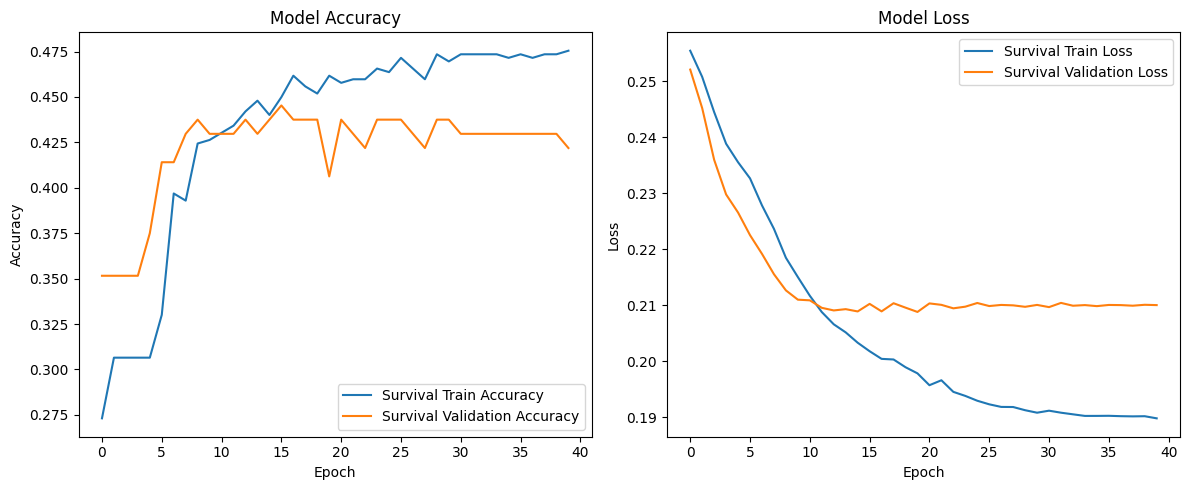

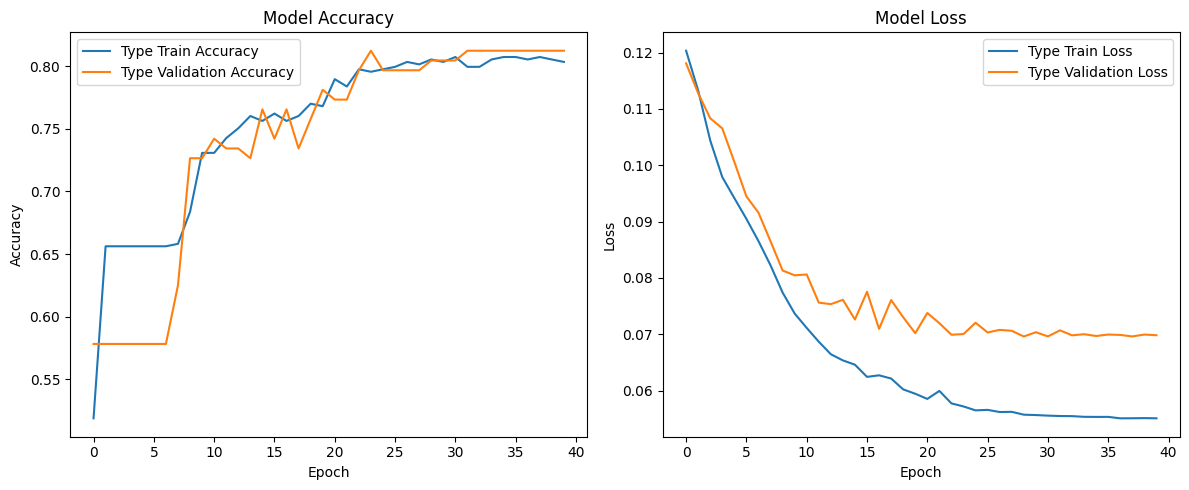

In [152]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğrulukları
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['st_accuracy'], label='Survival Train Accuracy')
plt.plot(history.history['val_st_accuracy'], label='Survival Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Eğitim ve doğrulama kayıpları
plt.subplot(1, 2, 2)
plt.plot(history.history['st_loss'], label='Survival Train Loss')
plt.plot(history.history['val_st_loss'], label='Survival Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğrulukları
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['type_accuracy'], label='Type Train Accuracy')
plt.plot(history.history['val_type_accuracy'], label='Type Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Eğitim ve doğrulama kayıpları
plt.subplot(1, 2, 2)
plt.plot(history.history['type_loss'], label='Type Train Loss')
plt.plot(history.history['val_type_loss'], label='Type Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [50]:
# Check shapes
print("y_categorical shape:", y_categorical.shape)
print("y2_categorical shape:", y2_categorical.shape)

# Predict — returns a list: [type_pred, st_pred]
y_pred_type, y_pred_st = model.predict([X, clinical_data])

# Convert one-hot labels to class indices
y_true_type = np.argmax(y_categorical, axis=1)
y_true_st = np.argmax(y2_categorical, axis=1)

# Convert predicted probabilities to class indices
y_pred_type = np.argmax(y_pred_type, axis=1)
y_pred_st = np.argmax(y_pred_st, axis=1)

# Print distributions
print("True TYPE classes:", np.unique(y_true_type, return_counts=True))
print("Pred TYPE classes:", np.unique(y_pred_type, return_counts=True))

print("True ST classes:", np.unique(y_true_st, return_counts=True))
print("Pred ST classes:", np.unique(y_pred_st, return_counts=True))

print("y_pred_type shape:", y_pred_type.shape)
print("y_true_type shape:", y_true_type.shape)

y_categorical shape: (797, 3)
y2_categorical shape: (797, 5)
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
True TYPE classes: (array([0, 1, 2]), array([185, 511, 101]))
Pred TYPE classes: (array([0, 1, 2]), array([184, 526,  87]))
True ST classes: (array([0, 1, 2, 3, 4]), array([ 75, 114, 163, 191, 254]))
Pred ST classes: (array([0, 1, 2, 3, 4]), array([ 72, 117, 163, 195, 250]))
y_pred_type shape: (797,)
y_true_type shape: (797,)


In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tahminler
y_pred_proba = model.predict([X_train, clinical_train])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_train, axis=1)

print("Gerçek sınıflar:", np.unique(y_true, return_counts=True))
print("Tahmin edilen sınıflar:", np.unique(y_pred, return_counts=True))

# Sadece mevcut sınıfları kullan
classes_present = np.unique(np.concatenate([y_true, y_pred]))

# Sınıf isimleri
label_names = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
labels_to_use = [label_names[i] for i in classes_present]

# Confusion matrix hesapla ve çiz
cm = confusion_matrix(y_true, y_pred, labels=classes_present)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_to_use)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Training Set)")
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 637) + inhomogeneous part.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<Figure size 600x600 with 0 Axes>

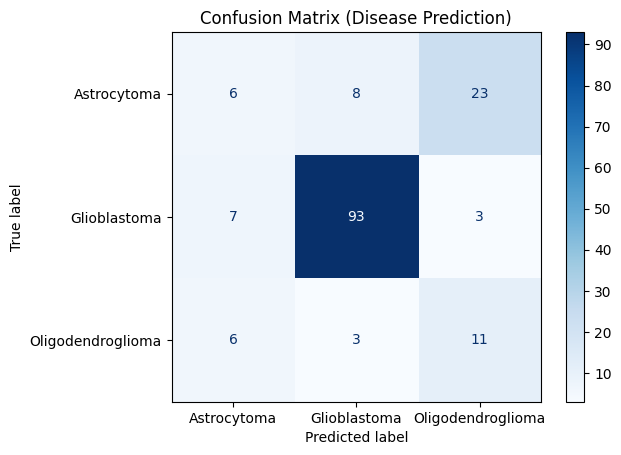

<Figure size 600x600 with 0 Axes>

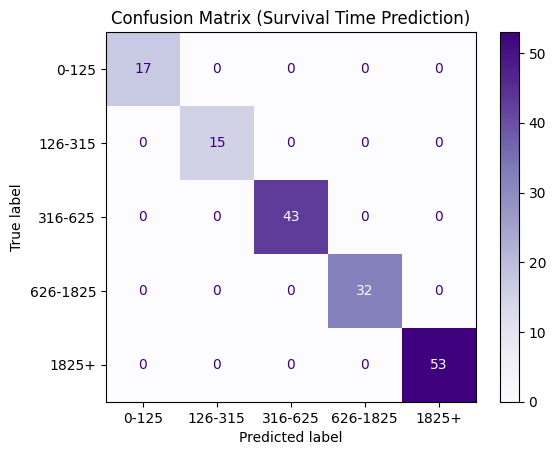

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model tahminleri (X_test ve clinical_test test verileri)
y_pred_proba = model.predict([X_test, clinical_test])

# Eğer model iki çıktı veriyorsa, y_pred_proba bir liste olur:
# [disease_predictions, survival_time_predictions]

# Her biri için argmax ile sınıf indexlerine çevir
y_pred_1 = np.argmax(y_pred_proba[0], axis=1)  # Hastalık sınıfı tahmini
y_pred_2 = np.argmax(y_pred_proba[1], axis=1)  # Yaşam süresi tahmini

# Ground truth'lar (one-hot -> sınıf indexi)
y_true_1 = np.argmax(y_test, axis=1)
y_true_2 = np.argmax(y2_test, axis=1)

# Sınıf etiketleri
label_names_1 = ['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']
label_names_2 = ['0-125', '126-315', '316-625', '626-1825', '1825+']

# -------- 1. Hastalık Confusion Matrix --------
cm1 = confusion_matrix(y_true_1, y_pred_1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=label_names_1)
plt.figure(figsize=(6, 6))
disp1.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Disease Prediction)")
plt.show()

# -------- 2. Yaşam Süresi Confusion Matrix --------
cm2 = confusion_matrix(y_true_2, y_pred_2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=label_names_2)
plt.figure(figsize=(6, 6))
disp2.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix (Survival Time Prediction)")
plt.show()

